# Kernel PCA and LLE Examples

+ Using the Swiss roll dataset.

### Packages

In [1]:
%matplotlib inline
# data and plotting packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import proj3d

# modeling packages
from sklearn.decomposition import KernelPCA
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.pipeline import Pipeline

from sklearn.datasets import make_swiss_roll

### Display Settings

In [2]:
#plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = (20, 10)
plt.rcParams['legend.fontsize'] = 'x-large'
plt.rcParams['axes.labelsize'] = 'x-large'
plt.rcParams['axes.titlesize'] = 'x-large'
plt.rcParams['xtick.labelsize'] = 'x-large'
plt.rcParams['ytick.labelsize'] = 'x-large'

### Create and plot a Swiss roll

We generate two linearly dependent features with some noise and run PCA.

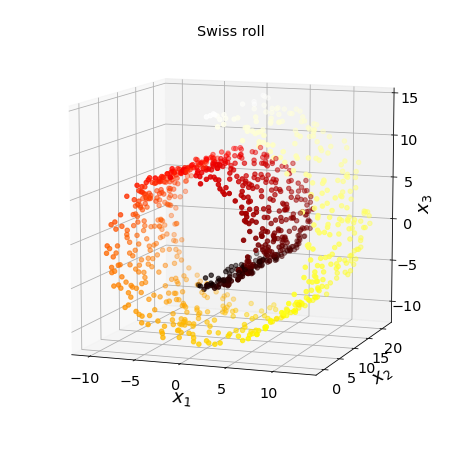

In [3]:
n_samples = 1000
noise = 0.2
rnd_state = 23

X, t = make_swiss_roll(n_samples=n_samples, noise=noise, random_state=rnd_state)

axlims = [-11.5, 14, -2, 23, -12, 15]

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=t, cmap=plt.cm.hot)
ax.view_init(10, -70)
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axlims[0:2])
ax.set_ylim(axlims[2:4])
ax.set_zlim(axlims[4:6])
ax.set_title("Swiss roll");

Linear projections on the coordinate planes are not good for separating the points by color.  
The correct transformation is to "unroll" the roll, along the coordinate "t" returned by the make_swiss_roll function.  
Below we plot the projection on the $x_1$-$x_2$ and $x_1$-$x_3$ planes, and the unrolling along the coordinate $t$.

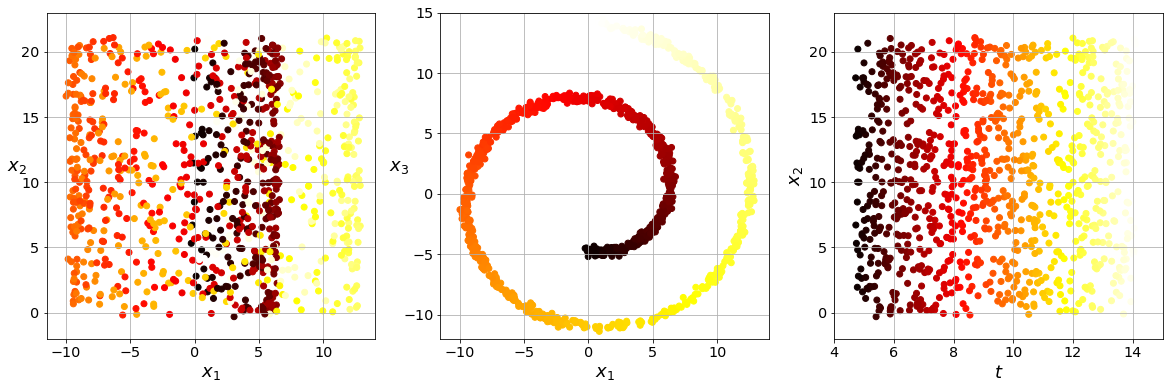

In [4]:
plt.figure(figsize=(20, 6))

plt.subplot(131)
plt.scatter(X[:, 0], X[:, 1], c=t, cmap=plt.cm.hot)
plt.axis(axlims[:4])
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.subplot(132)
plt.scatter(X[:, 0], X[:, 2], c=t, cmap=plt.cm.hot)
plt.axis(axlims[0:2] + axlims[4:6])
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_3$", fontsize=18, rotation=0)
plt.grid(True)

plt.subplot(133)
plt.scatter(t, X[:, 1], c=t, cmap=plt.cm.hot)
plt.axis([4, 15, axlims[2], axlims[3]])
plt.xlabel("$t$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18)
plt.grid(True)

## Fitting Kernel PCA
We use three different kernels, linear (standard PCA), RBF and Sigmoid.  
Then we plot the first two components.  
Note how color clusters are emerging.

In [5]:
lin_pca = KernelPCA(n_components = 2, kernel="linear", fit_inverse_transform=True)
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)
sig_pca = KernelPCA(n_components = 2, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True)

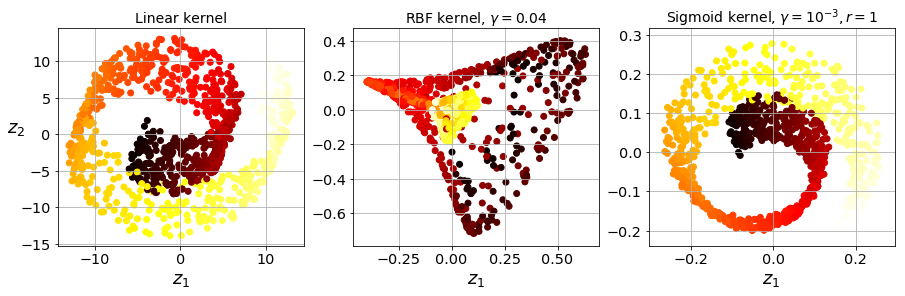

In [6]:
#y = t > 7.0

plt.figure(figsize=(15, 4))
for subplot, pca, title in ((131, lin_pca, "Linear kernel"), (132, rbf_pca, "RBF kernel, $\gamma=0.04$"), (133, sig_pca, "Sigmoid kernel, $\gamma=10^{-3}, r=1$")):
    X_red = pca.fit_transform(X)
    if subplot == 132:
        X_red_rbf = X_red
    
    plt.subplot(subplot)
    #plt.plot(X_red[y, 0], X_red[y, 1], "ro")
    #plt.plot(X_red[~y, 0], X_red[~y, 1], "k^")
    plt.title(title, fontsize=14)
    plt.scatter(X_red[:, 0], X_red[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

### Inverting the RBF kernel

We invert the kPCA to get the pre-image and plot it next to the original data set

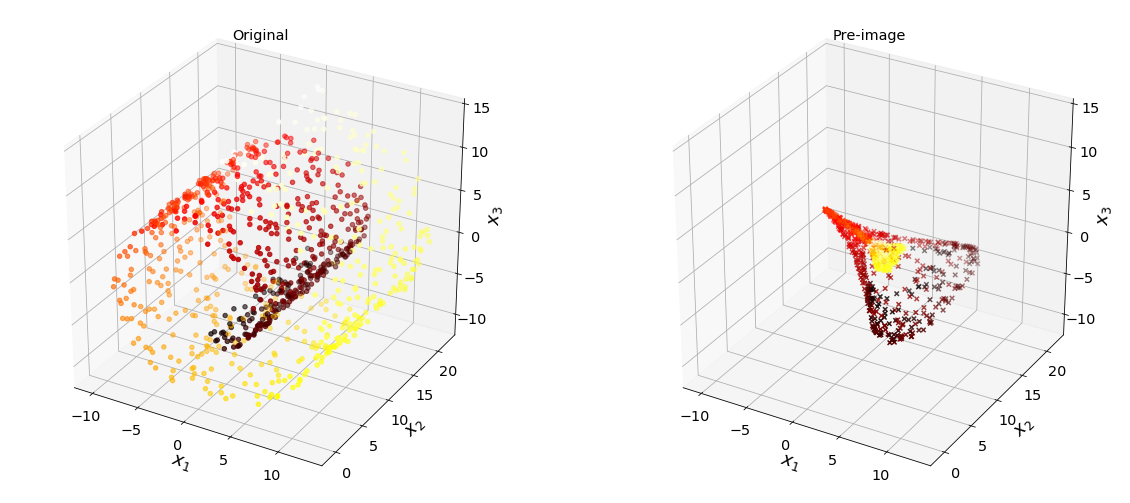

In [7]:
X_inv = rbf_pca.inverse_transform(X_red_rbf)

fig = plt.figure(figsize=(20, 9))

ax = fig.add_subplot(121, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=t, cmap=plt.cm.hot)
#ax.view_init(10, -70)
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axlims[0:2])
ax.set_ylim(axlims[2:4])
ax.set_zlim(axlims[4:6])
ax.set_title("Original");

ax = plt.subplot(122, projection='3d')
#ax.view_init(10, -70)
ax.scatter(X_inv[:, 0], X_inv[:, 1], X_inv[:, 2], c=t, cmap=plt.cm.hot, marker="x")
ax.set_xlim(axlims[0:2])
ax.set_ylim(axlims[2:4])
ax.set_zlim(axlims[4:6])
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_title("Pre-image");


## Grid Search
We set up a pipeline with kPCA as the preprocessing step and logistic regression as the classifier.   
We classify swiss roll points with color coordinate greater/less than a set value.


In [8]:
y = t > 7.0

clf = Pipeline([
        ("kpca", KernelPCA(n_components=2)),
        ("log_reg", LogisticRegression(solver="liblinear"))
    ])

param_grid = [{
        "kpca__gamma": np.linspace(0.03, 0.05, 10),
        "kpca__kernel": ["rbf", "sigmoid"]
    }]

grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X, y)

print("Best parameters")
print(grid_search.best_params_)

Best parameters
{'kpca__gamma': 0.03666666666666667, 'kpca__kernel': 'rbf'}


## Fitting LLE
We fit an LLE model.  
Then we plot the first two components.  
Note how the Swiss roll gets unrolled when projected back on the first two dimensions.

In [9]:
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_red = lle.fit_transform(X)

### Plotting the reconstructed image

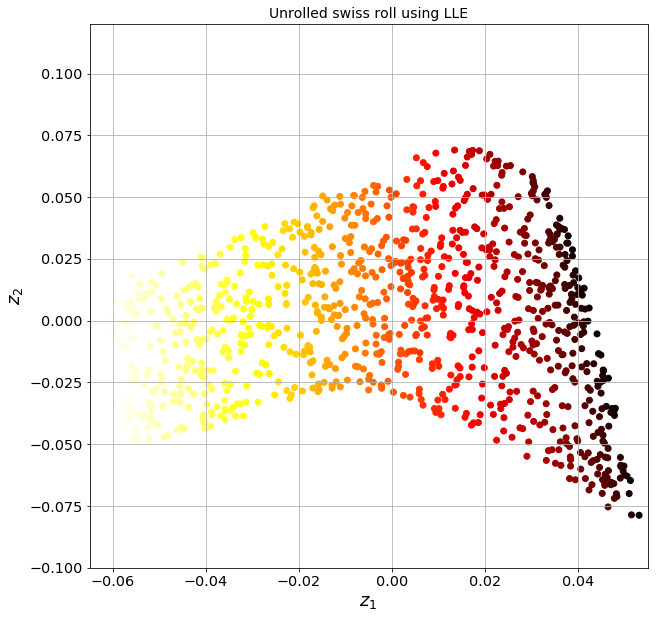

In [10]:
plt.figure(figsize=(10, 10))
plt.title("Unrolled swiss roll using LLE", fontsize=14)
plt.scatter(X_red[:, 0], X_red[:, 1], c=t, cmap=plt.cm.hot)
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18)
plt.axis([-0.065, 0.055, -0.1, 0.12])
plt.grid(True)